### Vegetation sensitivity

this notebook is to play around with veg and sort out why it varies extensively between 2010 and 2015

https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Frequently_used_code/Virtual_products.ipynb

In [95]:
import os, sys
import numpy as np
import pandas
from matplotlib import pyplot as plt

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
pandas.set_option('display.max_colwidth', 200)
pandas.set_option('display.max_rows', None)
dc = datacube.Datacube(app="veg_sensitivity")

In [105]:
# # 13, -28 (Central west QLD, 2010 veg, 2015 bare)
# x = (1300000, 1350000)
# y = (-2750000, -2700000)

# # 1, -25 (Central NT, 2010 veg, 2015 bare)
# x = (150000, 200000)
# y = (-2450000, -2500000)

# # 16, -40 (Nowra, 2010 veg, 2015 veg)
# x = (1650000, 1700000)
# y = (-3900000, -3950000)

# # -4, -22 (West SA, 2010 bare, 2015 bare - only slight change in veg)
# x = (-400000, -350000)
# y = (-3100000, -3150000)

# # 11, -48 (Southwest Tassie, 2010 veg 2015, bare 2015 - should be all veg/water, problem with obs count)
# x = (1150000, 1200000)
# y = (-4700000, -4750000)

# one pixel
x = (1101550, 1101650)
y = (-3970125, -3970225)
res = (-25, 25)

# res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")
query =({'x':x,
        'y':y,
        'crs':crs,
        'resolution':res})

query_time =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})

# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/r78/LCCS_Aberystwyth/co6850/'

In [106]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query_time)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian

<xarray.Dataset>
Dimensions:  (x: 4, y: 4)
Coordinates:
  * y        (y) float64 -3.97e+06 -3.97e+06 -3.97e+06 -3.97e+06
  * x        (x) float64 1.102e+06 1.102e+06 1.102e+06 1.102e+06
Data variables:
    blue     (y, x) float64 536.0 545.0 603.0 556.0 ... 637.0 628.0 526.0 466.0
    green    (y, x) float64 818.0 843.0 945.0 904.0 ... 999.0 876.0 809.0
    red      (y, x) float64 990.0 1e+03 1.069e+03 961.0 ... 1.15e+03 885.0 765.0
    nir      (y, x) float64 2.872e+03 2.995e+03 ... 3.136e+03 3.745e+03
    swir1    (y, x) float64 2.89e+03 2.79e+03 2.298e+03 ... 2.132e+03 2.328e+03
    swir2    (y, x) float64 1.799e+03 1.714e+03 1.46e+03 ... 1.271e+03 1.307e+03
Attributes:
    crs:      EPSG:3577

In [107]:
# geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

#### create the same virtual product as vegetat_veg_cat

In [108]:
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = str(service)+"livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_ingest import gridded_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

# datacube functions to load in a virtual product from recipe
from datacube.virtual import catalog_from_file
catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat_veg_testing.yaml')

In [109]:
# list(catalog)
# catalog['vegetat_veg_cat']

# load from datacube virtual product
product = catalog['vegetat_veg_cat']
data = product.load(dc, **query_time)

#### stepping through plugin rules

In [7]:
# select a scene to work through plugin rules
scene = 5

# looking at individual scenes for FC and WOfS
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
data.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
data.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
data.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
data.water.isel(time=scene).plot(cmap='magma')
ax4.set_title('water')

plt.tight_layout()
plt.show()

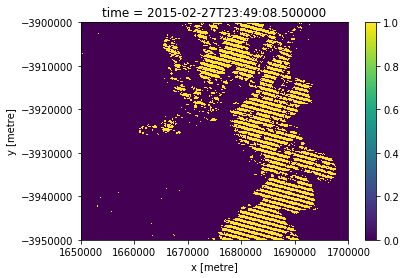

In [8]:
# Create mask where BS < PV
tv_mask = data['BS'] < data['PV']

tv_mask.isel(time=scene).plot()
# tv_mask.plot.imshow(col='time', col_wrap=5)

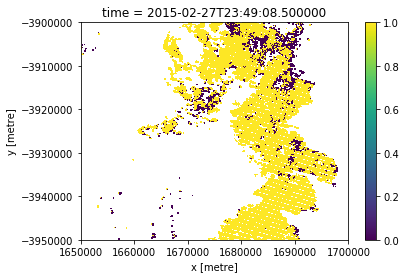

In [9]:
# Mask out where BS and PV values are 0 (remove no data)
tv = tv_mask.where((data['BS'] > 0) & (data['PV'] > 0))
tv.isel(time=scene).plot()

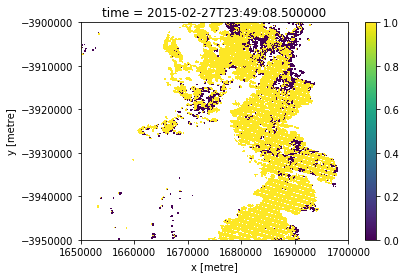

In [10]:
# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv.where((data['water'] != 128), 0)
tv = tv.where((data['water'] != 132), 0)
tv.isel(time=scene).plot()

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


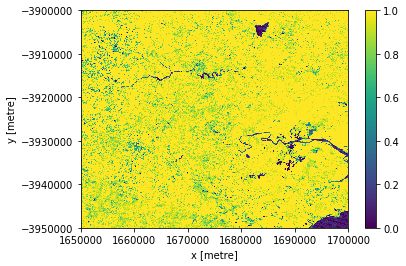

In [11]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.mean(dim='time')
tv_summary.plot()

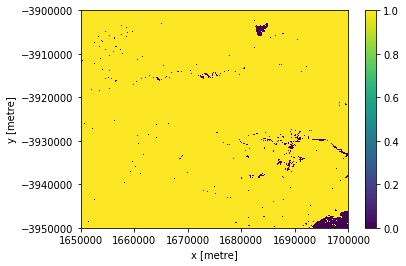

In [12]:
# Create a boolean layer where vegetation is assigned if greater than 0.167
tv_summary_filt = (tv_summary > 0.167).where(tv_summary.notnull())
tv_summary_filt.plot()

#### do we get the same result if we only use monthly data?
- need to groupby on a statistic for each month
- placement of where to groupby is difficult
- can use `time.month` or `time.day` or 'time.week' or `time.dayofyear` for some fortnightly combinations maybe?

http://xarray.pydata.org/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html
https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Frequently_used_code/Working_with_time.ipynb

#### monthly median 

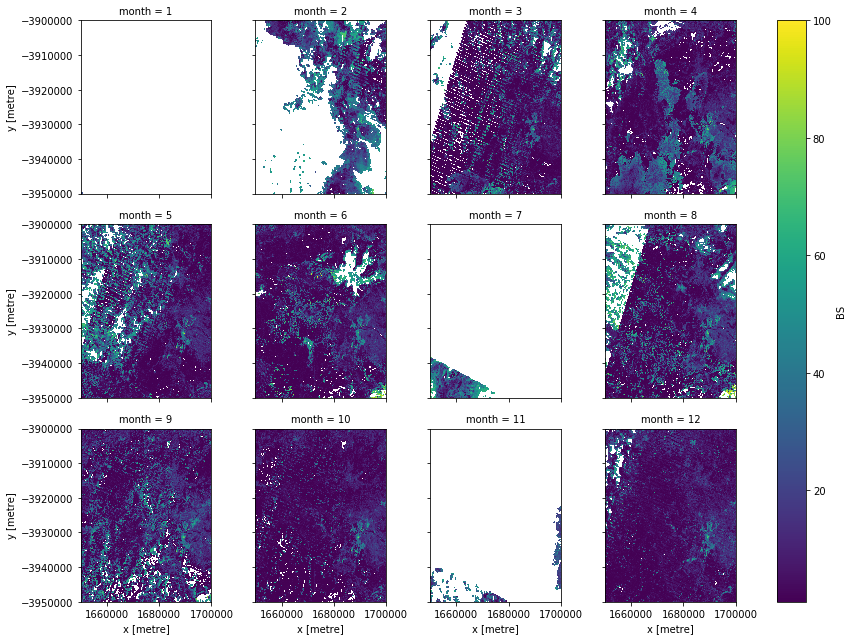

In [13]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')
data_month.BS.plot(col='month', col_wrap=4)

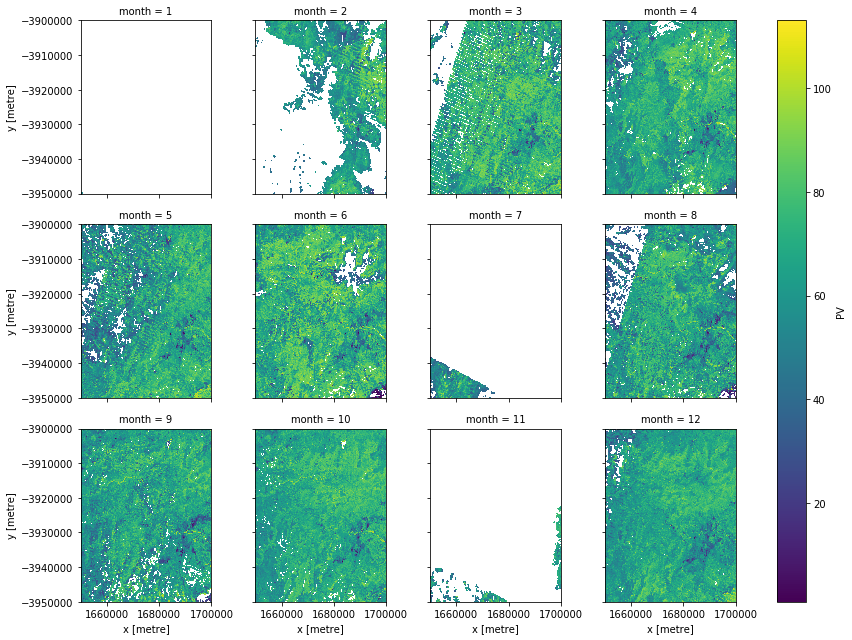

In [14]:
data_month.PV.plot(col='month', col_wrap=4)

In [15]:
# look at each month veg/non veg

# run pluging rules

# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)
tv.plot(col='month', col_wrap=4)

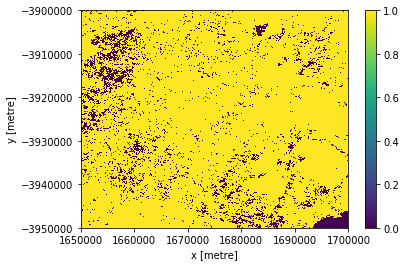

In [16]:
# run pluging rules

# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)

# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.mean(dim='month')

# Create a boolean layer where vegetation is assigned if greater than 0.167
tv_summary_filt = (tv_summary > 0.167).where(tv_summary.notnull())
tv_summary_filt.plot()

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


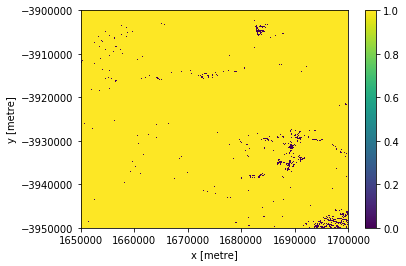

In [17]:
# run pluging rules with mask added like plugin has (even though we can done this above to get monthly medians)

# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']

# Mask out where BS and PV values are 0 (remove no data)
tv = tv_mask.where((data_month['BS'] > 0) & (data_month['PV'] > 0))

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv.where((data_month['water'] != 128), 0)
tv = tv.where((data_month['water'] != 132), 0)

# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.mean(dim='month')

# Create a boolean layer where vegetation is assigned if greater than 0.167
tv_summary_filt = (tv_summary > 0.167).where(tv_summary.notnull())
tv_summary_filt.plot()

#### weekly/fortnightly median 
- trying to bin fortnightly then do rule-based analysis and consectutive count to get 2 months of year

In [347]:
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_day = data_mask.time.dt.week
data_week = data_mask.groupby('time.week').median(dim='time')
data_week

<xarray.Dataset>
Dimensions:  (week: 30, x: 4, y: 4)
Coordinates:
  * y        (y) float64 -3.97e+06 -3.97e+06 -3.97e+06 -3.97e+06
  * x        (x) float64 1.102e+06 1.102e+06 1.102e+06 1.102e+06
  * week     (week) int64 2 4 6 7 8 9 11 13 14 15 ... 41 42 44 45 47 48 49 50 51
Data variables:
    BS       (week, y, x) float64 12.0 9.0 11.0 18.0 ... 19.0 24.0 19.0 18.0
    PV       (week, y, x) float64 35.0 36.0 31.0 23.0 ... 28.0 27.0 37.0 48.0
    NPV      (week, y, x) float64 52.0 54.0 57.0 57.0 ... 51.0 48.0 43.0 33.0
    water    (week, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [372]:
# group by week
data_week = data_mask.groupby('time.week').max(dim='time')
data_week
# data_week.plot(col='week', col_wrap=4)

# look at each week veg/non veg
# run pluging rules

# Create mask where BS < PV
tv_mask = data_week['BS'] < data_week['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_week['water'] != 128), 0)
tv = tv_mask.where((data_week['water'] != 132), 0)

# tv.plot(col='week', col_wrap=8)

In [373]:
# need to count consectutive weeks
# for each pixel see if 1,1,1,1,1,1,1,1 occurs

singlepx = tv.isel(x=1, y=1)
# singlepx.shape
tv = tv.transpose()
tv

<xarray.DataArray (x: 4, y: 4, week: 30)>
array([[[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
         1, 1, 0, 0, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 0, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 0, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 1]]])
Coordinates:
  * y        (y) float64 -3.97e+06 -3.97e+06 -3.97e+06 -3.97e+06
  * x        (x) float64 1.102e+06 1.102e+06 1.102e+06 1.102e+06
  * week     (week) int64 2 4 6 7 8 9 11 13 14 15 ... 41 42 44 45 47 48 49 50 51

In [362]:
'''
work with just one pixel
'''
# trying to get consectutive
def consecutive(x, stepsize=1):
    return np.split(x, np.where(np.diff(x) != stepsize)[0]+1)

# a binary classification
x = singlepx 

# create index of where x == 1
true_idx = np.where(x == 1)[0]

# split the elements by consecutive indicies
split = consecutive(true_idx)
del true_idx

# check if length of any arrays in split are >= 2:
if any(np.prod(arr.shape) > 2 for arr in split):
    veg = singlepx*1
    change = veg.max(dim='week')
    print(change)
else:
    veg = singlepx*0
    change = veg.max(dim='week')
    print(change)

<xarray.DataArray ()>
array(1)
Coordinates:
    y        float64 -3.97e+06
    x        float64 1.102e+06


In [374]:
'''
not working with whole dataset (4 pixels), iterates over week, not pixel
should work now withg transpose() - or need to reshape the data
'''

# trying to get consectutive
def consecutive(x, stepsize=1):
    return np.split(x, np.where(np.diff(x) != stepsize)[0]+1)

for arr in tv:
    
    # create index of where x == 1
    true_idx = np.where(arr == 1)[0]

    # split the elements by consecutive indicies
    split = consecutive(true_idx)
    del true_idx
    print(split)

    # check if length of any arrays in split are >= 2:
    if any(np.prod(arr.shape) > 2 for arr in split):
        veg = singlepx*1
        change = veg.max(dim='week')
        print(change)
    else:
        veg = singlepx*0
        change = veg.max(dim='week')
        print(change)
        

        
'''
before for loop introduced, was just look at one pixel, making consecutive arrays, then check if any of them had more than 8

    
# a binary classification
x = singlepx 

# create index of where x == 1
true_idx = np.where(x == 1)[0]

# split the elements by consecutive indicies
split = consecutive(true_idx)
del true_idx

# check if length of any arrays in split are >= 2:
if any(np.prod(arr.shape) > 8 for arr in split):
    veg = singlepx*1
    change = veg.max(dim='week')
    print(change)
else:
    veg = singlepx*0
    change = veg.max(dim='week')
    print(change)
'''
        # currently iterating for each week
    
    #     size = arr.size
#     Valid_list = Valid.append(size)
# print(Valid_list)
#     size.to_list()
    
    
#     if arr.size == 2:
#         veg = singlepx*5
#         change = singlepx.max(dim='week')
# #         write back into array
#         print(veg)




#     print(arr.size)
#     size = [np.array([arr.size])]
#     size = np.concatenate(size)
#     size = np.array([size])
#     print(size)

[array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0, 1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1, 2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2, 3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3]), array([3])]
<xarray.DataArray ()>
array(0)
Coordinates:
    y        float64 -3.97e+06
    x        float64 1.102e+06
[array([0]), array([0]), array([0]), array([

"\nbefore for loop introduced, was just look at one pixel, making consecutive arrays, then check if any of them had more than 8\n\n    \n# a binary classification\nx = singlepx \n\n# create index of where x == 1\ntrue_idx = np.where(x == 1)[0]\n\n# split the elements by consecutive indicies\nsplit = consecutive(true_idx)\ndel true_idx\n\n# check if length of any arrays in split are >= 2:\nif any(np.prod(arr.shape) > 8 for arr in split):\n    veg = singlepx*1\n    change = veg.max(dim='week')\n    print(change)\nelse:\n    veg = singlepx*0\n    change = veg.max(dim='week')\n    print(change)\n"

In [221]:
np.array([singlepx])

array([[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1]])

In [20]:
# using resample to get fortnight
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_fn = data_mask.resample(time='2w').max()
data_fn.time

# look at each fortnight veg/non veg
# run pluging rules

# Create mask where BS < PV
tv_mask = data_fn['BS'] < data_fn['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_fn['water'] != 128), 0)
tv = tv_mask.where((data_fn['water'] != 132), 0)

tv.plot(col='time', col_wrap=8)